### IMPORTANDO BIBLIOTECAS/MÓDULOS

In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import joblib

### CRIANDO SÉRIE TEMPORAL

In [2]:
np.random.seed(0)
data = np.random.normal(3000,1000,200)
serie = pd.DataFrame(data, columns=['Serie'])

### ANALISANDO SÉRIE TEMPORAL

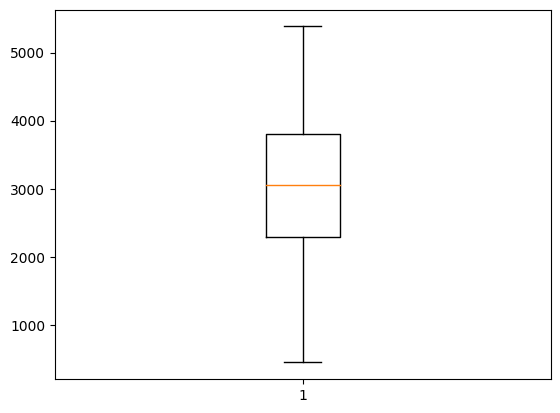

In [3]:
plt.boxplot(serie)
plt.show()

### PLOTANDO SÉRIE

<Axes: >

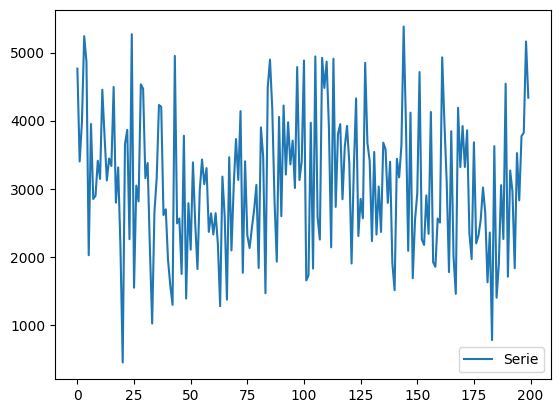

In [4]:
serie.plot()

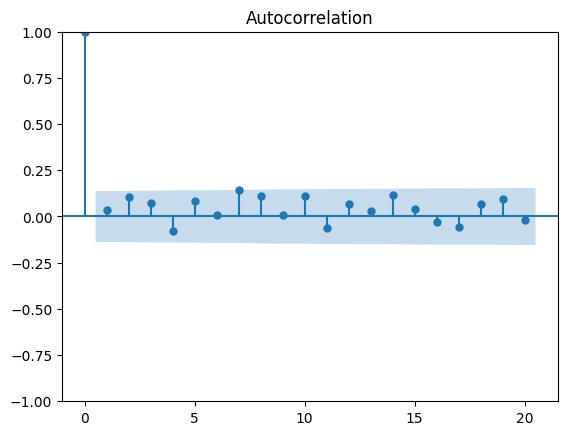

In [5]:
plot_acf(serie, lags=20)
plt.show()

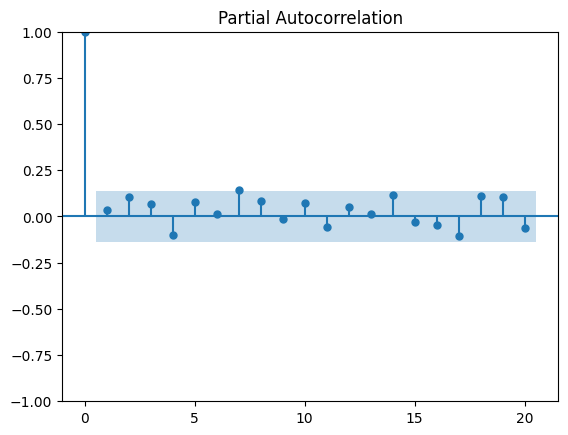

In [6]:
plot_pacf(serie, lags=20)
plt.show()

### DEFININDO BASE TREINO E TESTE

In [7]:
Treino = serie['Serie'][:int(len(serie) * 0.8)]
Teste = serie['Serie'][int(len(serie) * 0.8):]

print(Treino.shape)
print(Teste.shape)

(160,)
(40,)


### CONFIGURANDO E TREINANDO MODELOS ARIMA E SARIMAX

###### NO MODELO ARIMA, NÃO FOI NECESSÁRIO INCLUIR DIFERENCIAÇÃO, POIS A SÉRIE É ESTACIONÁRIA, TORNANDO O MODELO COMO 'ARMA'

In [41]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sa
import warnings

warnings.filterwarnings('ignore')

order_arima = (40,1,1)
order_sa = (20,1,1)
seasonal_order = (4,1,1,22)

modelo_sa = sa.tsa.SARIMAX(Treino, order=order_sa, seasonal_order=seasonal_order)
modelo = ARIMA(Treino,order=order_arima)

modelo_fit = modelo.fit()
modelo_sa_fit = modelo_sa.fit()

### AVALIANDO TREINAMENTO DOS MODELOS ARIMA E SARIMAX

In [42]:
residuals = pd.DataFrame(modelo_fit.resid)
residuals_sa = pd.DataFrame(modelo_sa_fit.resid)

In [43]:
print(modelo_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Serie   No. Observations:                  160
Model:                ARIMA(40, 1, 1)   Log Likelihood               -1301.791
Date:                Wed, 27 Sep 2023   AIC                           2687.581
Time:                        15:41:58   BIC                           2816.475
Sample:                             0   HQIC                          2739.924
                                - 160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0286      0.100     -0.288      0.774      -0.224       0.167
ar.L2          0.0460      0.108      0.425      0.671      -0.166       0.258
ar.L3          0.0198      0.105      0.189      0.8

In [44]:
print(modelo_sa_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Serie   No. Observations:                  160
Model:             SARIMAX(20, 1, 1)x(4, 1, 1, 22)   Log Likelihood               -1158.942
Date:                             Wed, 27 Sep 2023   AIC                           2371.884
Time:                                     15:41:59   BIC                           2450.723
Sample:                                          0   HQIC                          2403.922
                                             - 160                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0092      0.316     -0.029      0.977      -0.629       0.611
ar.L2          0.0259      

<Axes: ylabel='Density'>

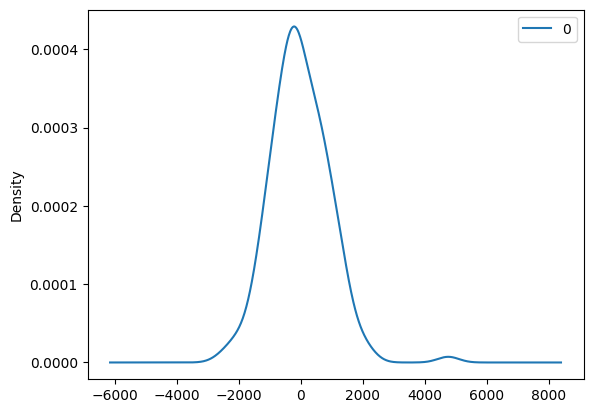

In [45]:
residuals.plot(kind='kde')

<Axes: ylabel='Density'>

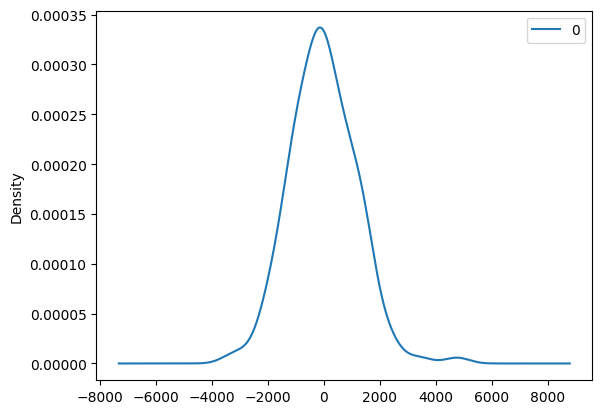

In [46]:
residuals_sa.plot(kind='kde')

### REALIZANDO PREVISÕES E COMPARANDO COM A BASE

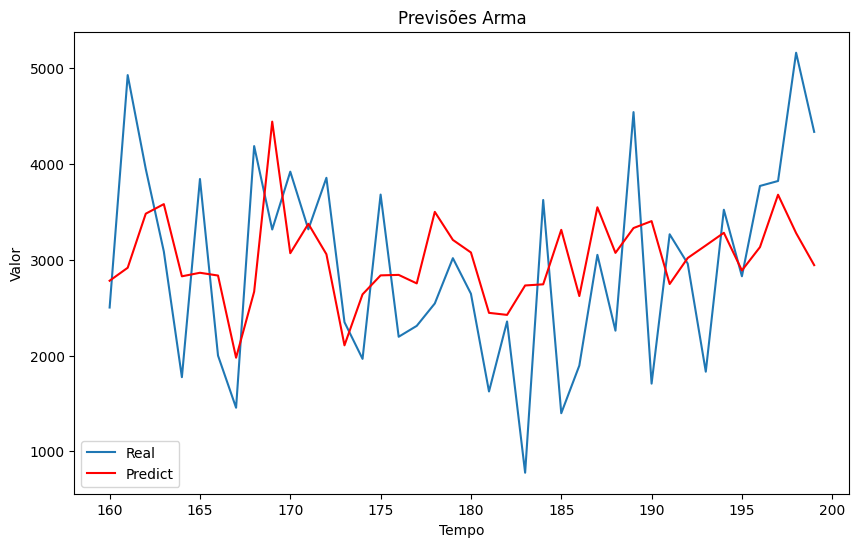

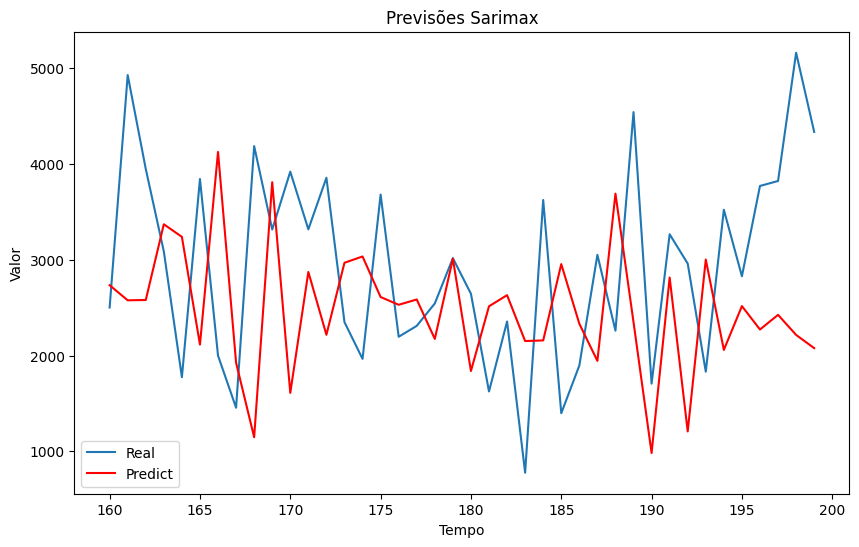

In [47]:
n_forecast = len(Teste)
forecast = modelo_fit.forecast(steps=n_forecast)
forcast_sa = modelo_sa_fit.forecast(steps=n_forecast)

predicts = [forecast,forcast_sa]

plt.figure(figsize=(10, 6))
plt.plot(Teste)
plt.plot(forecast, color='red')
plt.title('Previsões Arma')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(['Real', 'Predict'])

plt.figure(figsize=(10, 6))
plt.plot(Teste)
plt.plot(forcast_sa, color='red')
plt.title('Previsões Sarimax')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(['Real', 'Predict'])

plt.show()

### SALVANDO MODELOS

In [13]:
joblib.dump(modelo_fit,'arima.pkl')
joblib.dump(modelo_sa_fit,'sarimax.pkl')

['sarimax.pkl']

In [14]:
arima = joblib.load('arima.pkl')
sarima = joblib.load('sarimax.pkl')